# **Intro: Shot ambient classification**

In this notebook we've done a binary classification, specifically regarding the ambient in which an image has been shot: interior or exterior. We used a Convolutional Neural Network and different types of preprocessings (RGB, grayscale) and learning rates (0.0001, 0.001).

*Example of an **exterior** shot from the movie: "The Revenant"*

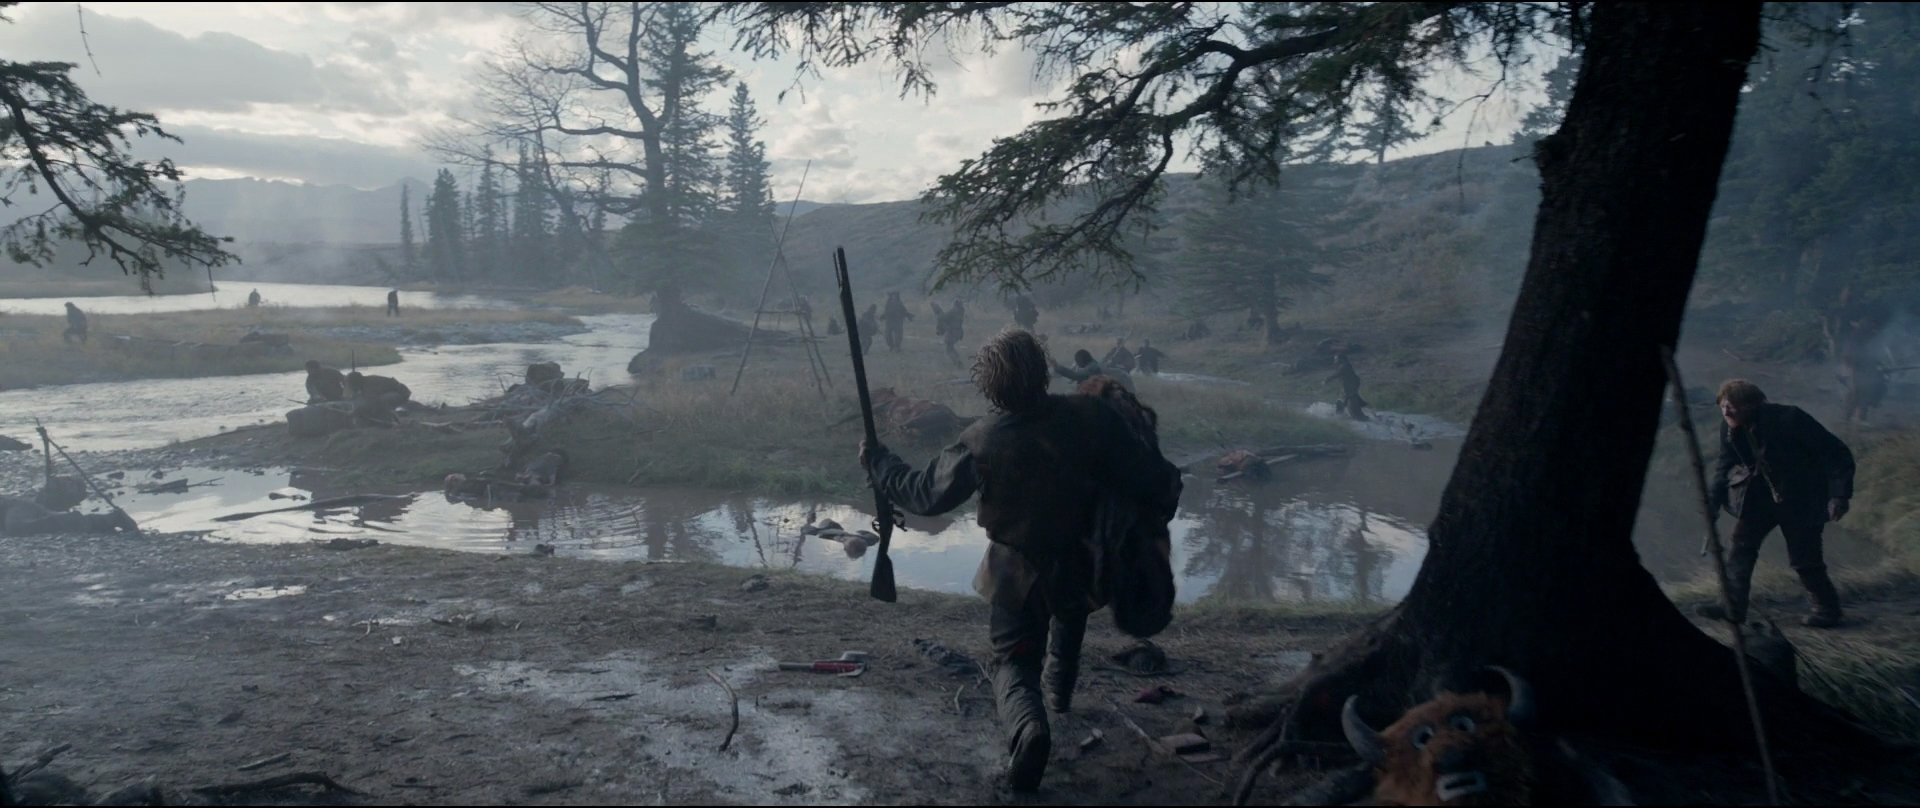

*Example of an **interior** shot from the movie: "Do the right thing"*

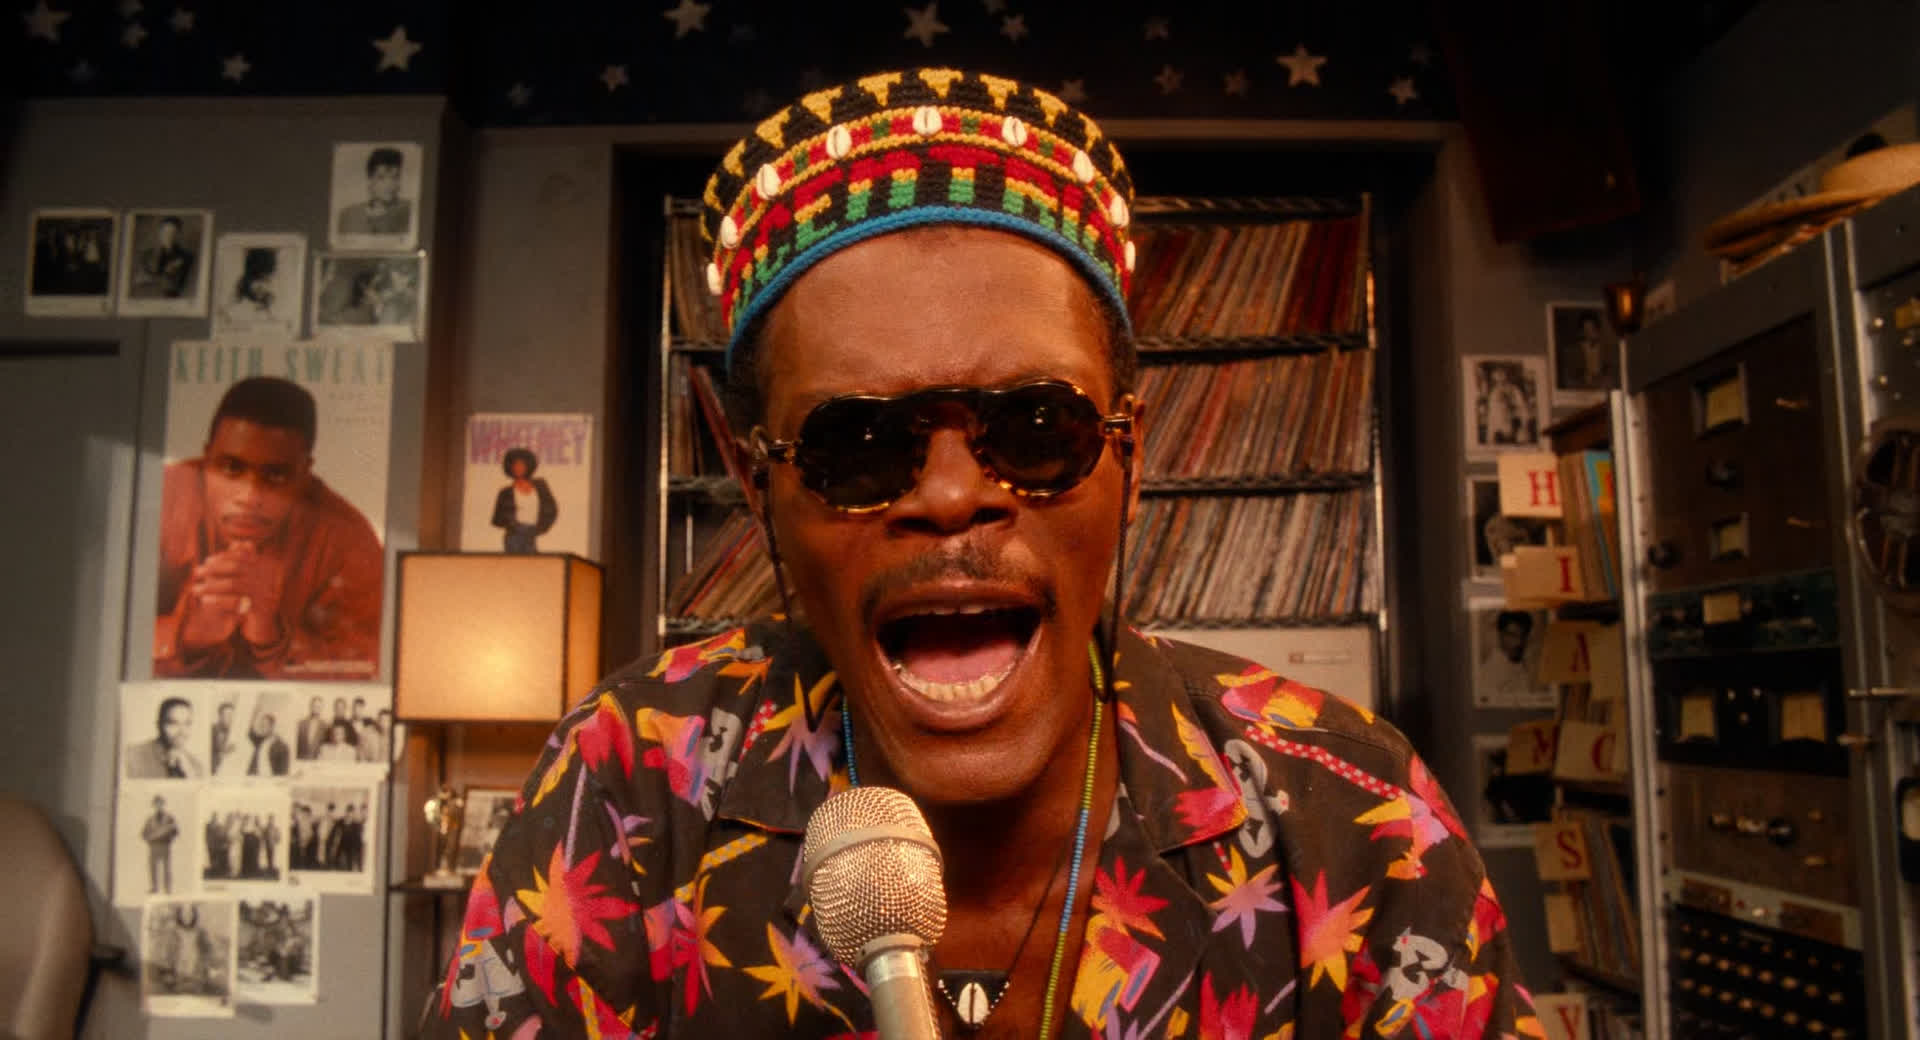

# **0. Global Constants**

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "<path>"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "<path>"
GDRIVE_DATA_CSV = GDRIVE_HOME_DIR + "<path>"

labels = {"interior" : 0, "exterior" : 1} # dictionary for the classes

RANDOM_SEED = 42 # for reproducibility

import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from PIL import Image, ImageOps
from google.colab import drive
import io

# Point Colaboratory to our Google Drive
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


# **1. Data Preprocessing**

### Creating a pandas version of the shot ambient dataframe

In [ ]:
url = GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/shot_ambient_binary_data.parquet"
pandas_df = pd.read_parquet(url)

Preprocessing functions to resize images into (224, 224) and transform them to grayscale and RGB.

In [ ]:
def resize_image_and_grayscale(content):
    image = Image.open(io.BytesIO(content))
    image = image.resize((224, 224))
    image = ImageOps.grayscale(image)
    array = np.asarray(image).astype('float32') / 255
    return array

In [ ]:
def resize_image_and_RGB(content):
    image = Image.open(io.BytesIO(content))
    image = image.resize((224, 224))

    # Check the shape of image and convert it to 'L' mode
    if image.mode == 'L': image = image.convert('RGB')
    array = np.asarray(image).astype('float32') / 255

    return array

# **2. Saving preprocessed datasets**

RGB

In [ ]:
resized_df = pandas_df.copy()
resized_df["content"] = resized_df.content.apply(lambda x : resize_image_and_RGB(x))

In [ ]:
resized_and_shuffled_df = resized_df.sample(frac=1)
resized_and_shuffled_df.to_pickle(GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/CNN/RGB/not_splitted/df.pkl")

grayscale

In [ ]:
resized_df = pandas_df.copy()
resized_df["content"] = resized_df.content.apply(lambda x : resize_image_and_grayscale(x))

In [ ]:
resized_and_shuffled_df = resized_df.sample(frac=1)
resized_and_shuffled_df.to_pickle(GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/CNN/grayscale/not_splitted/df.pkl")

# **3. Loading datasets and preparing them for the CNN**

In [ ]:
df_dict = {"RGB" : (3, pd.read_pickle(GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/CNN/RGB/not_splitted/df.pkl")),
           "grayscale" : (1, pd.read_pickle(GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/CNN/grayscale/not_splitted/df.pkl"))}

Function to convert to tensor and reshape the column "content" of the dataframe in order to use it as input for the CNN

In [ ]:
def to_np_array(df, col, channel):
  np_array = df[col].values
  return np.reshape(np.concatenate(np_array).ravel(), (len(df), 224, 224, channel))

In [ ]:
def reshape_and_split(df, channel):

    # reshaping X
    X = to_np_array(df, "content", channel)

    # reshaping y
    new_col = list(df["ambient"].apply(lambda x : labels[x]))
    y = np.reshape(new_col, (len(df), 1))

    # deleting df to save memory
    del df

    return X, y

Function to spit X and y into train, val and test

In [ ]:
def my_train_test_split(X, y, test_size = 0.2):
    i = int(len(X) * (1 - test_size))
    X_train, X_test = X[:i], X[i:]
    y_train, y_test  = y[:i], y[i:]
    return X_train, X_test, y_train, y_test

In [ ]:
for preprocessing in df_dict.keys():

    # We take the channel and the df from the dictionary
    channel, df = df_dict[preprocessing]
    print(preprocessing, ": ", channel)

    # We split the dataset into X and y
    X, y = reshape_and_split(df, channel)
    print(X.shape, y.shape)

    # And then divide into train, val and test
    X_train, X_test, y_train, y_test = my_train_test_split(X, y, test_size = 0.2)
    X_train, X_val, y_train, y_val = my_train_test_split(X_train, y_train, test_size = 0.25) # 0.25 x 0.8 = 0.2

    # deleting X and y to save memory
    del X, y

    # Save numpy arrays
    np.save(GDRIVE_HOME_DIR + f"/Big_Data/shot_ambient/CNN/{preprocessing}/X_train.npy", X_train)
    np.save(GDRIVE_HOME_DIR + f"/Big_Data/shot_ambient/CNN/{preprocessing}/y_train.npy", y_train)

    np.save(GDRIVE_HOME_DIR + f"/Big_Data/shot_ambient/CNN/{preprocessing}/X_val.npy", X_val)
    np.save(GDRIVE_HOME_DIR + f"/Big_Data/shot_ambient/CNN/{preprocessing}/y_val.npy", y_val)

    np.save(GDRIVE_HOME_DIR + f"/Big_Data/shot_ambient/CNN/{preprocessing}/X_test.npy", X_test)
    np.save(GDRIVE_HOME_DIR + f"/Big_Data/shot_ambient/CNN/{preprocessing}/y_test.npy", y_test)

    # deleting the splittings to save memory
    del X_train, X_val, y_train, y_val, X_test, y_test

RGB :  3
(9018, 224, 224, 3) (9018, 1)
grayscale :  1
(9018, 224, 224, 1) (9018, 1)


# **4. Convolutional Neural Network**

Loading numpy arrays

In [ ]:
def load_arrays(preprocess_dir_name, show_shape = True):

  path = GDRIVE_HOME_DIR + '/Big_Data/shot_ambient/CNN/' + preprocess_dir_name

  X_train = np.load(path + "/X_train.npy", allow_pickle=True)
  y_train = np.load(path + "/y_train.npy", allow_pickle=True)

  X_val = np.load(path + "/X_val.npy", allow_pickle=True)
  y_val = np.load(path + "/y_val.npy", allow_pickle=True)

  X_test = np.load(path + "/X_test.npy", allow_pickle=True)
  y_test = np.load(path + "/y_test.npy", allow_pickle=True)

  if show_shape:
      print("Train Data Shape:        ", X_train.shape)
      print("Train Labels Shape:      ", y_train.shape)
      print("\nValidation Data Shape:   ", X_val.shape)
      print("Validation Labels Shape: ", y_val.shape)
      print("\nTest Data Shape:         ", X_test.shape)
      print("Test Labels Shape:       ", y_test.shape, "\n")

  return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pickle

In here we set the architecture of the model that we're going to use

In [ ]:
def init_model(input_shape):

    model = tf.keras.models.Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')])

    return model

In [ ]:
init_model((224,224,3)).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
def train_model(model, train_gen, val_gen, num_epochs, preprocess_name, lr):

  steps_per_epoch = train_gen.n // train_gen.batch_size
  val_steps = val_gen.n // val_gen.batch_size+1

  history = model.fit(  train_gen,
              validation_data=val_gen,
              epochs=num_epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=val_steps)

  model_path = GDRIVE_HOME_DIR + '/Big_Data/shot_ambient/CNN/models/' + preprocess_name + '_' + str(lr) + '_100epochs.h5'
  model.save(model_path)

  history_path = GDRIVE_HOME_DIR + '/Big_Data/shot_ambient/CNN/models/' + preprocess_name + '_' + str(lr) + '_100epochs'

  with open(history_path, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)

  del model, train_gen, val_gen

In [ ]:
def pipeline(X_train, y_train, X_val, y_val, preprocessing_name, num_epochs = 50, batch_size = 32, lr = 0.0001):

  # instantiates the model
  model = init_model(PREPROCESSINGS[preprocessing_name])

  # some prints to visualize better the whole thing
  print("Preprocessing type:", preprocessing_name, "\n")
  print(model.summary(), "\n")
  print(f"lr = {lr}, batch_size of datagen = {batch_size}\n")

  # compile the model with binary crossentropy loss and Adam optimizer
  model.compile(optimizer=Adam(learning_rate = lr), loss='binary_crossentropy', metrics=['accuracy'])

  # Data augmentation
  train_datagen = ImageDataGenerator(
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

  train_generator = train_datagen.flow(
      X_train,
      y_train,
      shuffle=True,
      seed=RANDOM_SEED,
      batch_size=batch_size)

  val_datagen = ImageDataGenerator()
  val_generator = val_datagen.flow(
        X_val,
        y_val,
        batch_size=batch_size)

  train_model(model, train_generator, val_generator, num_epochs, preprocessing_name, lr)

  del train_datagen, train_generator, val_datagen, val_generator

In [ ]:
PREPROCESSINGS = {"RGB" : (224, 224, 3), "grayscale" : (224, 224, 1)}

learning_rate_list = [0.0001, 0.001]

In [ ]:
# looping through the preprocessings to fit the models and save them for future use
for preprocessing in PREPROCESSINGS:

    # loading arrays
    X_train, y_train, X_val, y_val, _, _ = load_arrays(preprocessing)

    for lr in learning_rate_list:

        # calling the pipeling function to execute compile and fit of the desired neural network
        pipeline(X_train, y_train, X_val, y_val, preprocessing, lr = lr, num_epochs = 100)
        print("\n------------------------------------------------------------------------\n\n")

    del X_train, y_train, X_val, y_val

# **5. Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_model_metrics(model, X_test, y_test, model_name):

  predictions = model.predict(X_test)

  predicted_labels = np.array([[1] if x > 0.5 else [0] for x in predictions])

  accuracy = accuracy_score(y_test, predicted_labels)
  print("Accuracy:", accuracy)

  f1 = f1_score(y_test, predicted_labels, average='weighted')
  print("F1 Score:", f1)

  confusion_mtx = confusion_matrix(y_test, predicted_labels)

  # Normalize the confusion matrix
  confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
  class_names = labels.keys()

  return confusion_mtx, class_names, model_name

In [ ]:
import matplotlib.pyplot as plt

def plot_matrix_and_history(confusion_mtx, class_names, model_name, history):

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the confusion matrix heatmap
    sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, cmap="Blues", ax=axs[0])
    axs[0].set_xlabel('Predicted Labels')
    axs[0].set_ylabel('True Labels')
    axs[0].set_title(model_name)

    # Plot the training and validation loss
    axs[1].plot(history['loss'], label='train')
    axs[1].plot(history['val_loss'], label='val')
    axs[1].set_title('Training vs Val Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    # Plot the training and validation accuracy
    axs[2].plot(history['accuracy'], label='train')
    axs[2].plot(history['val_accuracy'], label='val')
    axs[2].set_title('Training vs Val Accuracy')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Accuracy')
    axs[2].legend()

    plt.tight_layout()  # to adjust spacing between subplots
    plt.show()

In [ ]:
PREPROCESSINGS = {"RGB" : (224, 224, 3), "grayscale" : (224, 224, 1)}

learning_rate_list = [0.0001, 0.001]

57/57 [==============================] - 1s 22ms/step
Accuracy: 0.7860310421286031
F1 Score: 0.7858788181614696


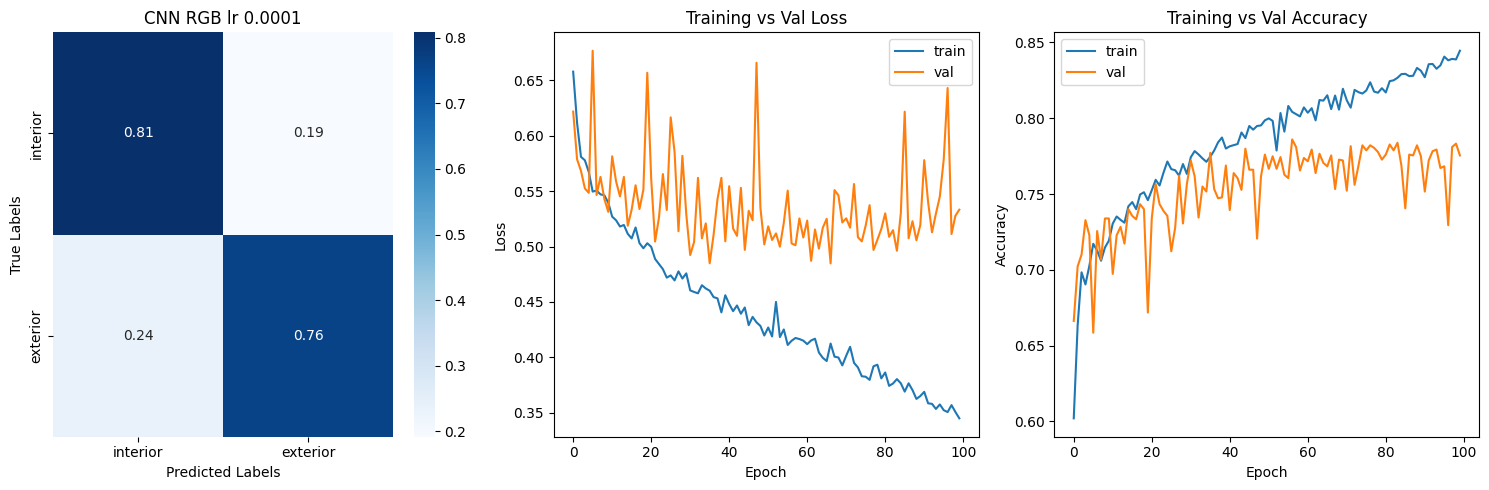

57/57 [==============================] - 1s 21ms/step
Accuracy: 0.7799334811529933
F1 Score: 0.7796209543482492


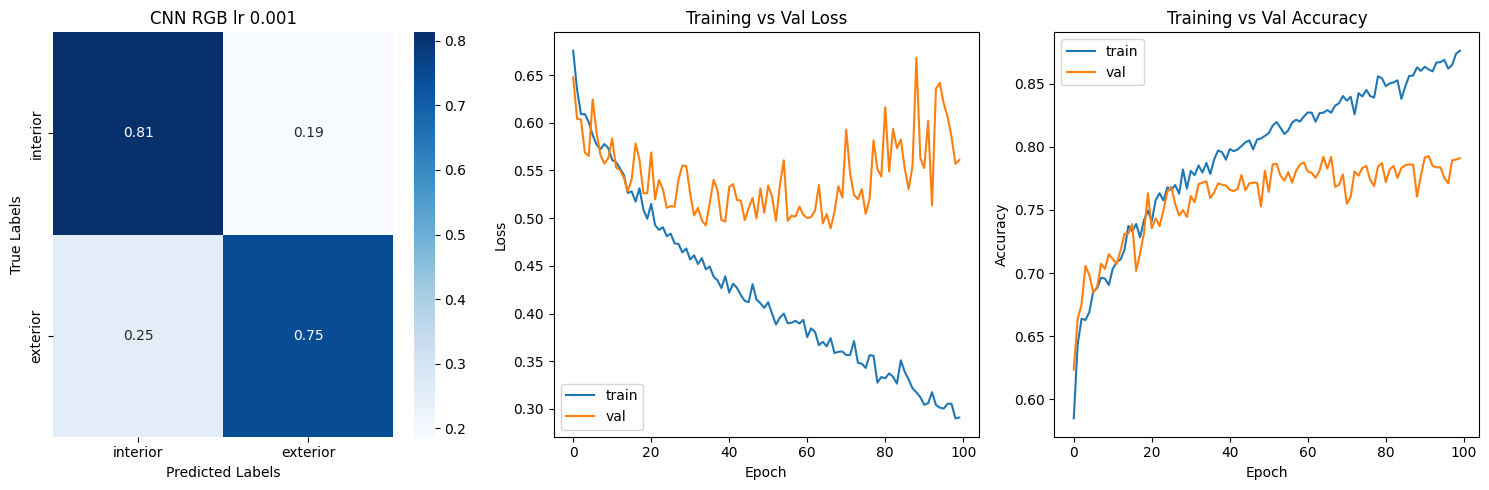

57/57 [==============================] - 1s 15ms/step
Accuracy: 0.7815964523281597
F1 Score: 0.7817598692926241


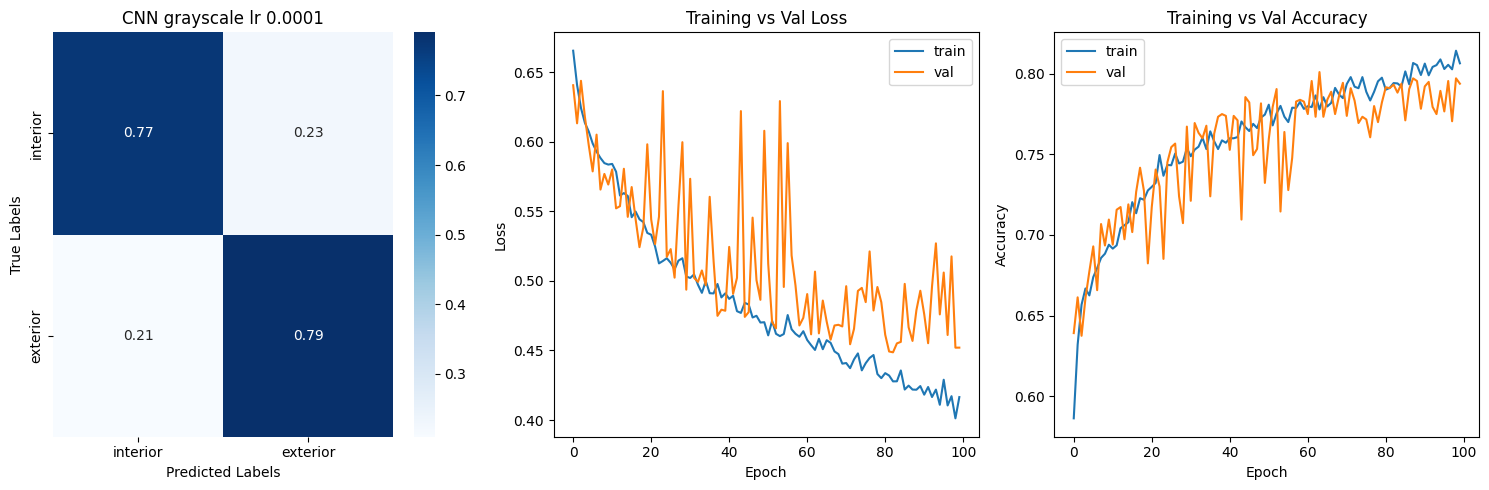

57/57 [==============================] - 1s 14ms/step
Accuracy: 0.7644124168514412
F1 Score: 0.7644848820614888


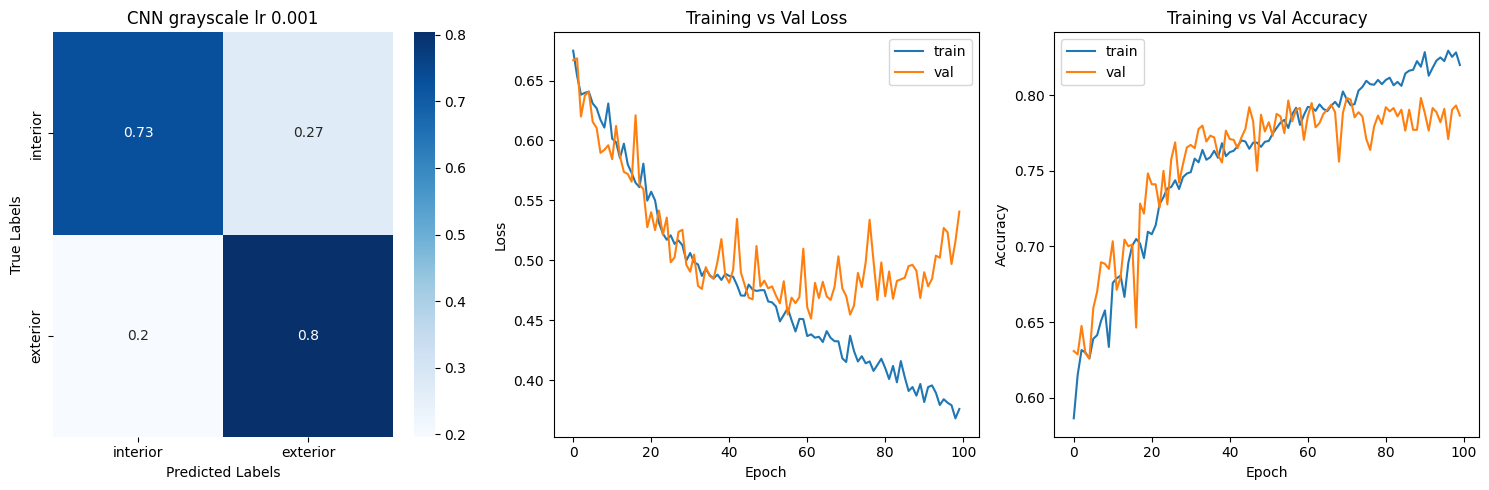

In [ ]:
import pickle # to load history of the model

for preprocessing in PREPROCESSINGS.keys():

  _, _, _, _, X_test, y_test = load_arrays(preprocessing, show_shape=False)

  for lr in learning_rate_list:

      # load the model
      model_path = GDRIVE_HOME_DIR + '/Big_Data/shot_ambient/CNN/models/' + preprocessing + '_' + str(lr) + "_" + '100epochs.h5'
      model = keras.models.load_model(model_path)

      # load model history
      history_path = model_path[:-3]
      with open(history_path, 'rb') as file_pi:
          saved_history = pickle.load(file_pi)

      # get model metrics
      confusion_mtx, class_names, model_name  = get_model_metrics(model, X_test, y_test, f"CNN {preprocessing} lr {lr}")

      # plot confusion matrix and history of the model
      plot_matrix_and_history(confusion_mtx, class_names, model_name, saved_history)

# **6. Visualize images and predicted labels**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def get_predictions(model, X_test):

    # list with continuous values between 0 and 1 (percentage)
    Y_pred = model.predict(X_test)

    # list with the predictions [or 0 or 1]
    y_preds =  [1 if i > 0.5 else 0 for i in [round(i[0],0) for i in Y_pred]]

    return Y_pred, y_preds

In [ ]:
def to_image(np_array, mode):
  if mode == "L": np_array = np.reshape(np_array, (224,224))
  int_array = (np_array * 255).astype(np.uint8)
  img = Image.fromarray(int_array, mode)
  return img

In [ ]:
decode_labels = {0 : "interior", 1 : "exterior"}

In [ ]:
# Function to generate an NxN matrix of images in this order [interior-interior, exterior-exterior, interior-exterior, exterior-interior]
def createListOfImages(N, y_preds, y_test):

  ii, ee, ie, ei = [], [], [], [] # create lists
  c = N * 4

  for i in range(len(y_test)):

      if y_test[i][0] == y_preds[i]:
          if y_preds[i] == 0 and len(ii) < N:
              ii.append(i)
              c -= 1
          elif y_preds[i] == 1 and len(ee) < N:
              ee.append(i)
              c -= 1
      else:
          if y_preds[i] == 0 and len(ei) < N:
              ei.append(i)
              c -= 1
          elif y_preds[i] == 1 and len(ie) < N:
              ie.append(i)
              c -= 1

      if c == 0: break

  return [ii, ee, ie, ei]

In [ ]:
def pretty_print_percentage(num, y_preds, Y_pred):
    prediction = y_preds[num]
    if prediction == 0: percentage = round(1 - Y_pred[num][0], 2)
    else: percentage = round(Y_pred[num][0], 2)
    return "{:.0%}".format(percentage)

In [ ]:
def plot_matrix(title, matrix, mode, y_preds, Y_pred):

  w, h = len(matrix), len(matrix[0])
  f, axarr = plt.subplots(w, h + 1, figsize = (18, 12))

  f.suptitle(title)

  axarr[0, 0].axis("off")
  axarr[0, 0].text(0.1, 0.5, 'Groundtruth:  Interior\nPrediction:     Interior')
  axarr[1, 0].axis("off")
  axarr[1, 0].text(0.1, 0.5, 'Groundtruth:  Exterior\nPrediction:     Exterior')
  axarr[2, 0].axis("off")
  axarr[2, 0].text(0.1, 0.5, 'Groundtruth:  Interior\nPrediction:     Exterior')
  axarr[3, 0].axis("off")
  axarr[3, 0].text(0.1, 0.5, 'Groundtruth:  Exterior\nPrediction:     Interior')

  for i in range(w):
    for j in range(h):
      axarr[i, j + 1].axis("off")
      axarr[i, j + 1].imshow(to_image(X_test[matrix[i][j]], mode))
      axarr[i, j + 1].text(0, 0, pretty_print_percentage(matrix[i][j], y_preds, Y_pred))

  plt.show()

In [ ]:
PREPROCESSINGS = {"RGB" : (224, 224, 3), "grayscale" : (224, 224, 1)}

learning_rate_list = [0.0001, 0.001]

RGB 0.0001
57/57 [==============================] - 74s 1s/step


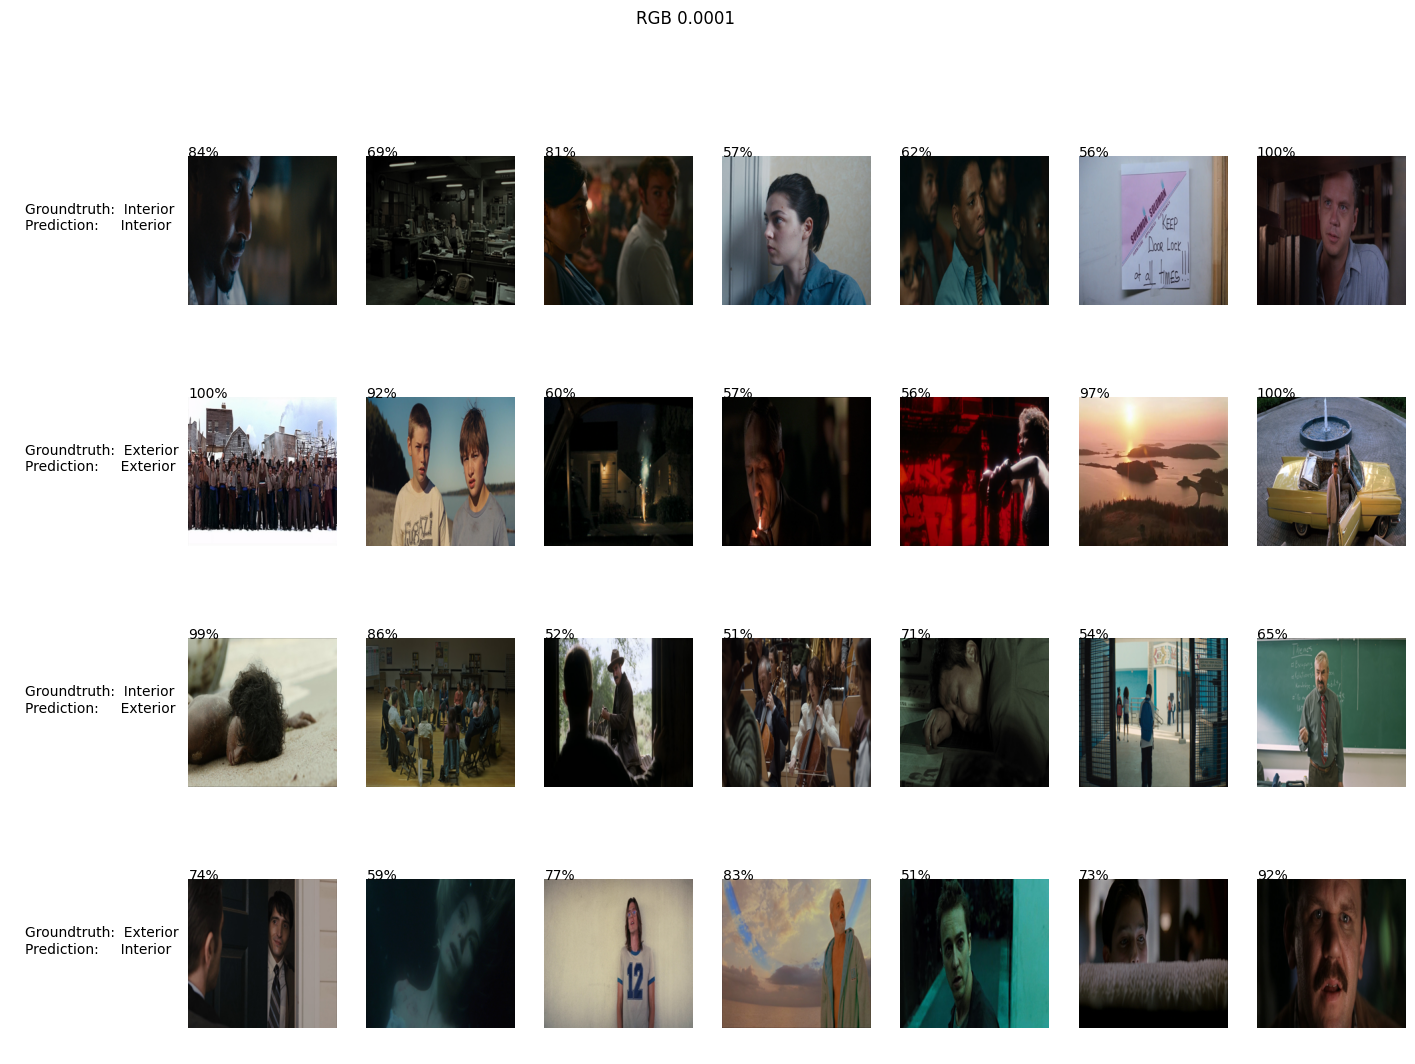

RGB 0.001
57/57 [==============================] - 74s 1s/step


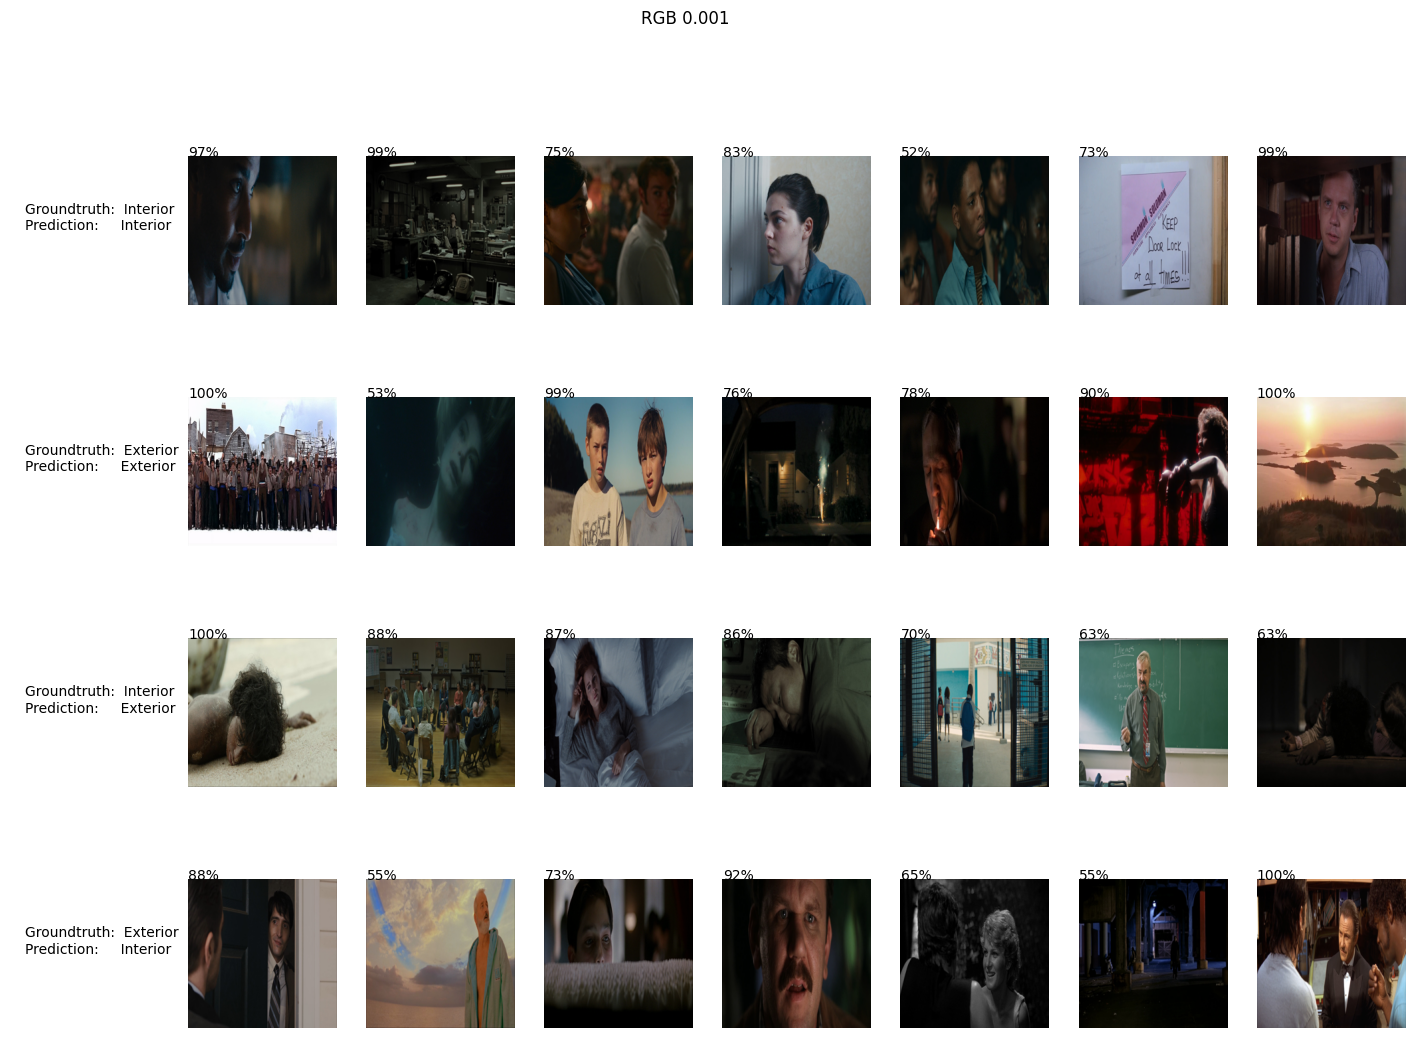

grayscale 0.0001
57/57 [==============================] - 69s 1s/step


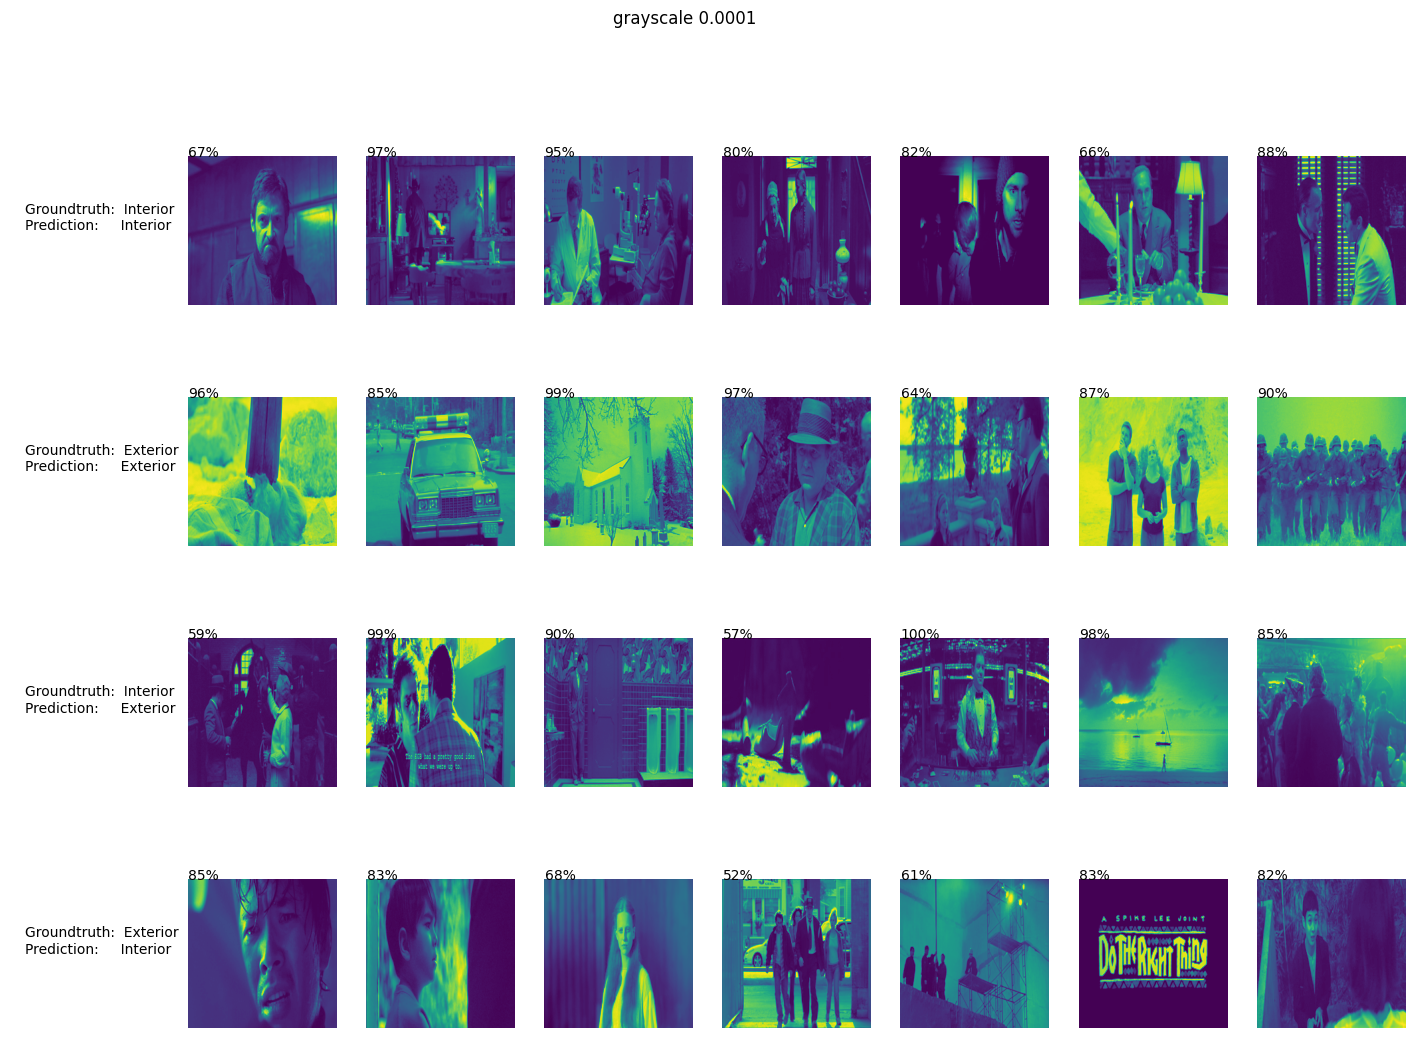

grayscale 0.001
57/57 [==============================] - 75s 1s/step


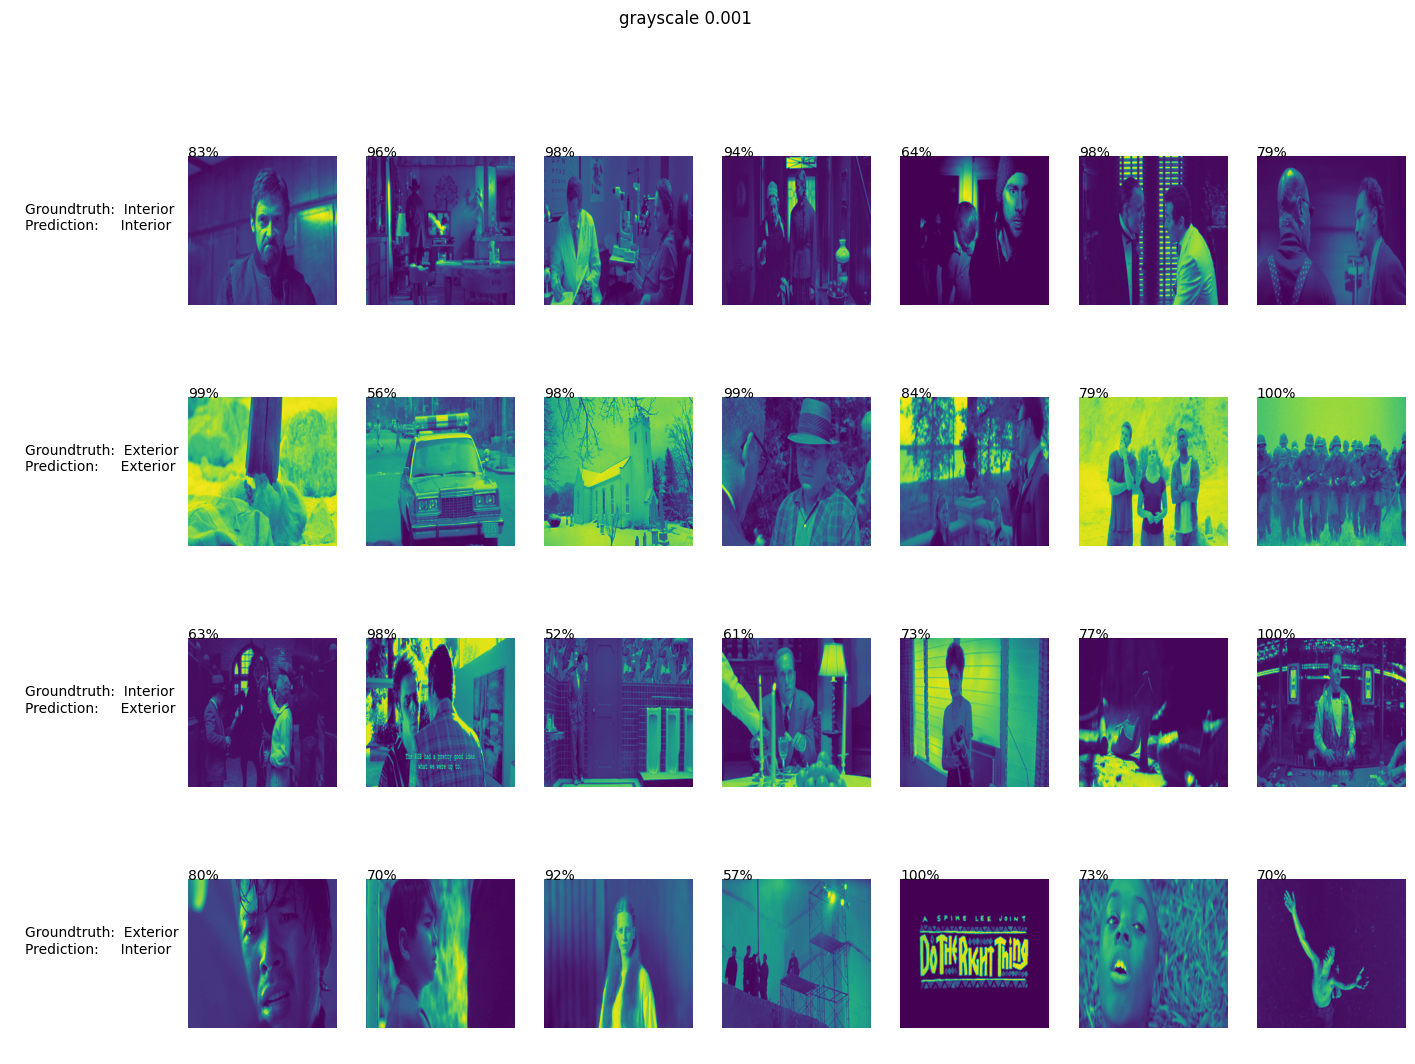

In [ ]:
for preprocessing in PREPROCESSINGS.keys():

  _, _, _, _, X_test, y_test = load_arrays(preprocessing, show_shape=False)

  for lr in learning_rate_list:

      # load the model
      model_path = GDRIVE_HOME_DIR + '/Big_Data/shot_ambient/CNN/models/' + preprocessing + '_' + str(lr) + '_100epochs.h5'
      model = keras.models.load_model(model_path)

      print(preprocessing, lr)

      # get the predictions from our function
      Y_pred, y_preds = get_predictions(model, X_test)

      # create the matrix with the 4 possible outcomes [ii, ee, ie, ei]
      matrix = createListOfImages(7, y_preds, y_test)

      # define the mode of the image
      mode = "L" if preprocessing == "grayscale" else "RGB"

      # plot the image
      plot_matrix(f"{preprocessing} {lr}", matrix, mode, y_preds, Y_pred)

# **7. Conclusions**

It appears that all 4 models aren't performing that good and we can see why in those images. It's very difficult sometimes to understand if the ambient of the image is interior or exterior only from an image. It could be so dark that you cannot really see anything, the background could be misleading or the shot could take place at the entrance of a building or anything else. All these reasons obviously affect the accuracy of the model and on top of these there is another possible reason, which is the human error on classifying the images.

**P.S. The comparison of the approaches is reported in the second notebook on the classification of shot ambient types.**